### Reading csv

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression
from dotenv import load_dotenv

os.load()
api_key = os.environ.get('API_KEY2')

#### Thingspeak Data

In [2]:
url = f"https://thingspeak.com/channels/1575525/feed.csv?apikey={api_key}&timezone=Asia/Singapore"

df=pd.read_csv(
    url,
    header=0, 
    parse_dates=['created_at']
    )

# Removing timezone from 'Timestamp'
df['created_at'] = df['created_at'].dt.tz_localize(None)
df= df.iloc[:, [0, -2, -1]]
df.rename(columns={'field1': 'water_level', 'field2': 'dispensed_count'}, inplace=True)
df.head()

,created_at,water_level,dispensed_count
0,2021-11-27 12:58:12,593.0,19
1,2021-11-27 12:58:53,716.0,20
2,2021-11-27 12:59:09,707.0,24
3,2021-11-27 12:59:25,688.0,31
4,2021-11-27 12:59:41,677.0,38


#### Fabricated Data

In [3]:
path = 'sanitizer_records.csv'

df = pd.read_csv(
    path,
    parse_dates=['Timestamp']
)

df.tail()

,Timestamp,water_level,dispensed_count
85,2021-11-18 20:52:00,290,225
86,2021-11-19 10:18:00,630,1
87,2021-11-19 10:19:00,610,2
88,2021-11-19 10:20:00,603,3
89,2021-11-19 10:24:00,590,4


### Creating a function to customize graph

In [4]:
def custom(plot, xlabel, ylabel, title, size):
    plot.set_xlabel(xlabel, fontsize=size, labelpad=size)
    plot.set_ylabel(ylabel, fontsize=size, labelpad=size)
    plot.set_title(title, fontsize=size+4, pad=size+2)
    plot.tick_params(axis='both', which='major', labelsize=12)

### Plotting of graphs for data analysis

* Water Level time trend
* Plotting dispense count

**Both graphs will be plotted based on maximum of 2 days basis**, to provide higher readability and easier analysis

(18949.791666666668, 18950.999988425927)

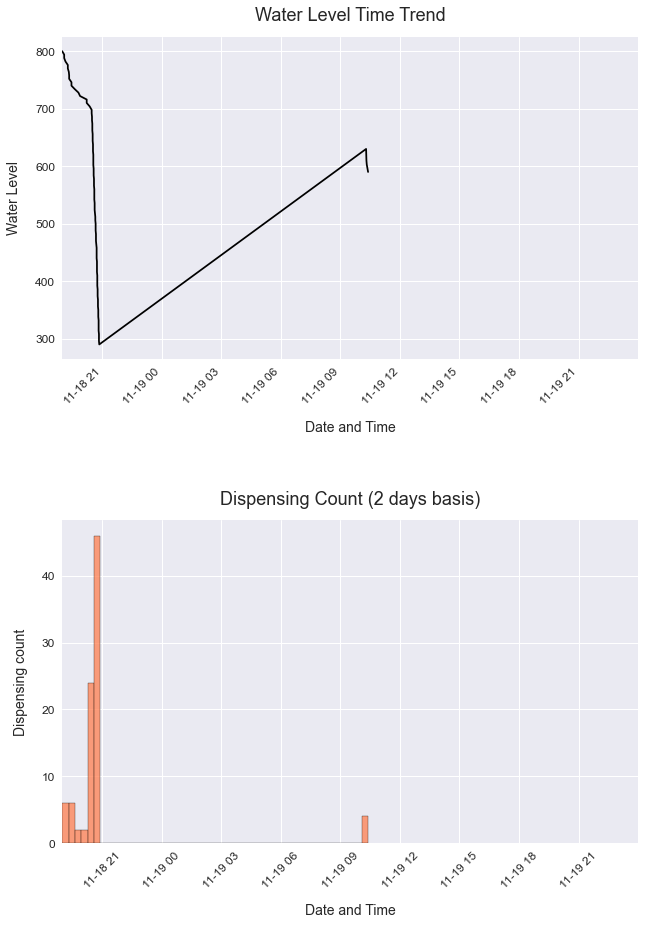

In [5]:
plt.style.use('seaborn')
fig=plt.figure(figsize = (10, 16))
subplot1=fig.add_subplot(2,1,1)
subplot2=fig.add_subplot(2,1,2)
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.7, hspace=0.5)

# Plotting Water Level time trend
df.plot(x='Timestamp', y='water_level', kind='line' , ax=subplot1 , legend = None , color='k', rot=45)
# Plotting dispense count 
sns.histplot(data = df, x='Timestamp', ax=subplot2, color='coral', bins=48)

# Customization
plt.xticks(rotation=45)
custom(subplot1, "Date and Time", "Water Level", "Water Level Time Trend", 14)
custom(subplot2, "Date and Time", "Dispensing count", "Dispensing Count (2 days basis)", 14)
subplot1.set_xlim(df.loc[0, 'Timestamp'], pd.Timestamp('2021-11-19 23:59:59'))
subplot2.set_xlim(df.loc[0, 'Timestamp'], pd.Timestamp('2021-11-19 23:59:59'))

### Plot regression plot between water level and dispensing count

* To see whether there is a linear trend between these 2 variables

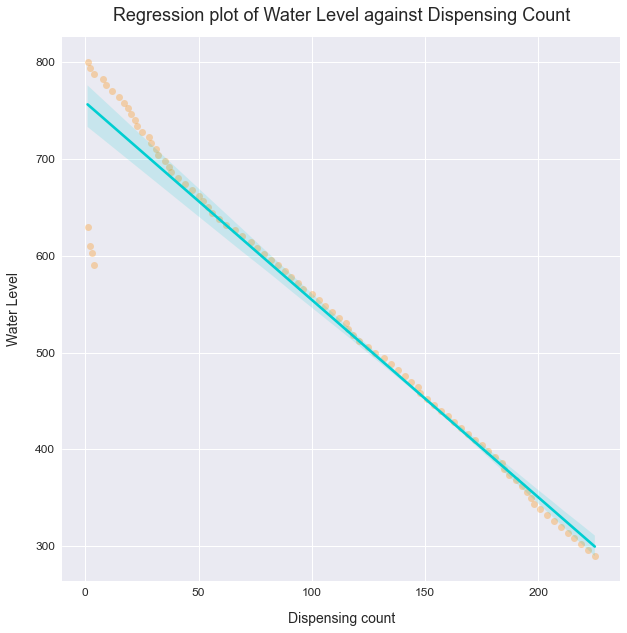

In [6]:
plot_object = plt.subplots(1,1, figsize=(10, 10))
fig, ax = plot_object
sns.regplot(
    x=df.loc[:, 'dispensed_count'], 
    y=df.loc[:, 'water_level'], 
    ax=ax, 
    color='darkturquoise',
    scatter_kws={'alpha': 0.3, 'color': 'darkorange'}
    )

custom(ax, "Dispensing count", "Water Level", "Regression plot of Water Level against Dispensing Count", 14)

Calculate the correlation between water level and dispensing count

In [7]:
print(f"The correlation between water level and dispensed count: {df['water_level'].corr(df['dispensed_count'])}")

The correlation between water level and dispensed count: -0.9728689040466711


This means that the feature have a negative relationship with the target variable, which means:

* An increase in X variable is associated with a decrease in Y variable

Since the correlation coefficient is ~ -0.97, **this suggest that water level has high negative correlation with dispensed_count**

### Creating a simple linear regression model

In [8]:
model = LinearRegression()

water_train = df[['water_level']]
disp_train = df[['dispensed_count']]
model.fit(water_train.values, disp_train.values)

LinearRegression()

**Prediction with our linear regression model with regards to these 2 conditions**
1. Water Level between 675.0 and 450 (MEDIUM)
2. Water Level below 450 (LOW)

The purpose of this is to find out the number of times the user have to dispense to reach condition 2 and 3

In [9]:
water_predict = model.predict([[674], [449]])
water_predict

array([[ 44.63194237],
       [149.12064247]])

1. It takes about ~45 counts to reach Medium water level
2. It takes about ~150 counts to reach Low water level

**~150 counts, the user can consider refilling the sanitizer**

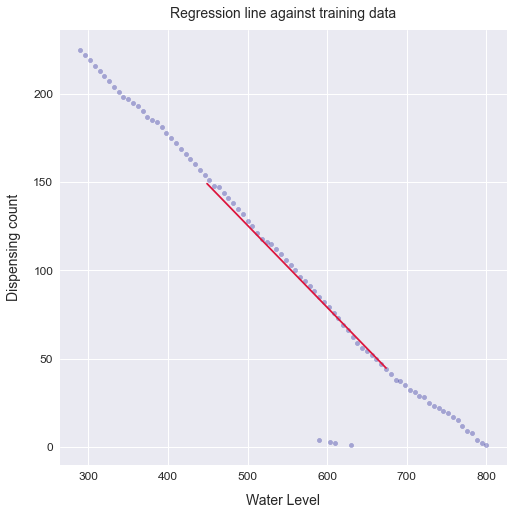

In [10]:
plot_object = plt.subplots(1,1, figsize=(8, 8))
fig, predict = plot_object
# Plot out the training data as scatter
df.plot(x='water_level', y='dispensed_count', kind='scatter', ax=predict, alpha=0.3, color='darkblue')

# Plot out the predicted line
predict.plot([674, 449], water_predict, color='crimson')

# Customize the graph
predict.set_ylabel("Dispensing count", fontsize=14, labelpad=12)
predict.set_xlabel("Water Level", fontsize=14, labelpad=12)
predict.set_title("Regression line against training data", fontsize=14, pad=12)
predict.tick_params(axis='both', which='major', labelsize=12)

### Splitting data to train and validation dataset

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
water_level_data = df[['water_level']] # Must always be a 2D array
dispensed_count_data = df[['dispensed_count']]

# Splitting data into 30 % test, 70% train
water_train, water_test, disp_train, disp_test = train_test_split(water_level_data, dispensed_count_data, test_size=0.3, random_state=42)

water_test.head()

,water_level
40,560
22,668
55,470
70,380
0,800


**Predict using test set**

In [13]:
disp_predict = model.predict(water_test.values)
disp_predict

array([[ 97.57288375],
       [ 47.41830771],
       [139.36836379],
       [181.16384383],
       [-13.88172968],
       [ 58.56376905],
       [ 94.78651842],
       [167.23201715],
       [ 13.98192367],
       [108.7183451 ],
       [211.81386253],
       [ 83.64105707],
       [142.15472913],
       [ 65.06528817],
       [ 19.55465435],
       [ -2.73626834],
       [ 36.27284636],
       [ 64.13649972],
       [122.65017178],
       [158.87292114],
       [189.52293984],
       [178.3774785 ],
       [197.88203585],
       [ 69.70923039],
       [ 78.0683264 ],
       [ 16.76828901],
       [170.01838249]])

**Calculating R-squared values**

In [14]:
R_squared = model.score(water_test.values, disp_test.values)
print(f"R_squared for linear regression model is {R_squared}")

R_squared for linear regression model is 0.9607153792174863


**Plotting actual against predicted data**

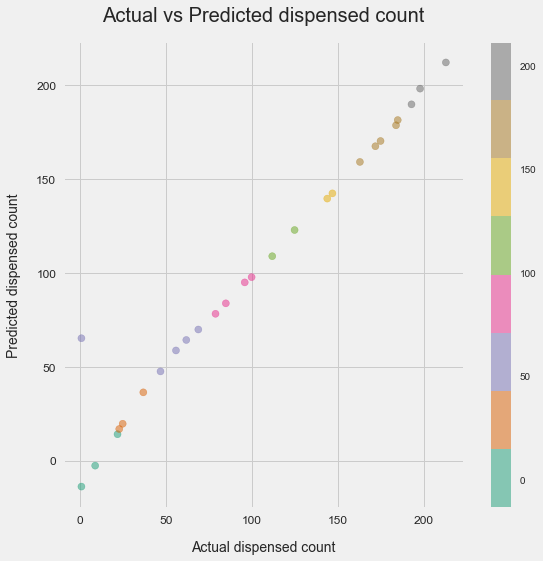

In [16]:
plot_object1 = plt.subplots(1, 1, figsize=(8, 8))
fig, ax = plot_object1
plot = ax.scatter(disp_test, disp_predict, alpha=0.5, c=disp_predict, cmap='Dark2')

# Customizing graph
plt.style.use('fivethirtyeight')
ax.set_xlabel("Actual dispensed count", fontsize=14, labelpad=15)
ax.set_ylabel("Predicted dispensed count", fontsize=14, labelpad=15)
ax.set_title("Actual vs Predicted dispensed count", fontsize=20, pad=20)
ax.tick_params(axis='both', which='major', labelsize=12)
fig.colorbar(plot)